# Economics Problem 3
### Shekhar Kumar

### Question 3.1

### The Bellman equation is given by 

$$ V(k_{t},z_{t}) = \max_{c_t}  [u(c_{t})] + \beta E[V(k_{t+1},z_{t+1})]  $$

where

$$ c_{t} = (1-\delta)k_{t} + z_{t}k_{t}^\alpha - k_{t+1} $$

where 
$$ \ln(z_{t}) =  \rho\ln(z_{t-1}) + \nu_{t} $$

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fminbound
import scipy.optimize as opt
import numba
import ar1_approx as ar1

# to print plots inline
%matplotlib inline

In [2]:
beta = 0.96
gamma = 0.50
delta =  0.05
alpha = 0.4
mu = 0.0
rho = 0.8
sigma_v = 0.10

'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital(k) grid
ub_k      = scalar, upper bound of capital(k) grid 
size_k    = integer, number of grid points in kapital state space
k_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
lb_k = 10.0
ub_k = 20.0 
size_k = 120  # Number of grid points for capital grid
size_eps = 120 # Number of grid points for shock grid
k_grid = np.linspace(lb_k, ub_k, size_k)
# Use the Adda Cooper method suggested by Jason
shock_z, trans_p =  ar1.addacooper(size_eps,mu, rho,sigma_v)
shock_grid = np.exp(shock_z)
prob = np.transpose(trans_p)

In [3]:
def utility(C,gamma):
    U = (C ** (1 - gamma)) / (1 - gamma)
    return U  

In [4]:
''' Create a three dimesional utility array with dimensions for k,k' and z.
Once the utility has been calculated at each of the value in this array. 
Take a mean value in the z dimension to get a 2-D array for Expected utility
'''
C =  np.zeros((size_k, size_k, size_eps))

@numba.jit
def C_loop(size_k,size_eps,delta,k_grid,shock_grid,alpha):
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k'
            for s in range(size_eps): #loop over z shock
                C[i,j,s] =   (1-delta)*k_grid[i] + shock_grid[s]*k_grid[i]**alpha-k_grid[j]

    return C

C =  C_loop(size_k,size_eps,delta,k_grid,shock_grid,alpha)
C[C<0] = 1e-6
U = utility(C,gamma) 
U[C == 1e-6] = -1e6

## Step 2: Value Function Iteration

In [5]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of k , k, and shock'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8
VFdist = 7.0 
VFmaxiter = 2000 
V = np.zeros((size_k,size_eps) )# initial guess at value function
Vmat = np.zeros((size_k, size_k,size_eps)) # initialize Vmat matrix
Vstore = np.zeros((size_k,size_eps, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    @numba.jit
    def VFI_loop(size_k,Vmat,beta,V,size_eps,prob,U):
        for i in range(size_k): # loop over k
            for j in range(size_k): # loop over k'
                for s in range(size_eps):
                    EU = 0
                    for ss in range(size_eps):
                        EU += prob[s, ss]*V[j, ss]
                        Vmat[i, j,s] = U[i, j,s] + beta * EU
        return Vmat
    Vmat =  VFI_loop(size_k,Vmat,beta,V,size_eps,prob,U)
    Vstore[:,:, VFiter] = V.reshape(size_k,size_eps,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    print("Iteration ", VFiter, "dist =", VFdist)
    V = TV
    VFiter += 1 
    
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Iteration  1 dist = 7.542154661289247
Iteration  2 dist = 4.127350738851586
Iteration  3 dist = 3.561701083814336
Iteration  4 dist = 3.2158528246402653
Iteration  5 dist = 2.9567459808515686
Iteration  6 dist = 2.746029349105523
Iteration  7 dist = 2.5675230967157106
Iteration  8 dist = 2.412123751868066
Iteration  9 dist = 2.274713936565391
Iteration  10 dist = 2.150865988302918
Iteration  11 dist = 2.0384361100493678
Iteration  12 dist = 1.935974749769656
Iteration  13 dist = 1.841950799175649
Iteration  14 dist = 1.7550994889917746
Iteration  15 dist = 1.6744191941005866
Iteration  16 dist = 1.5990724836446333
Iteration  17 dist = 1.5284359098477154
Iteration  18 dist = 1.4619760176827938
Iteration  19 dist = 1.3992365737817067
Iteration  20 dist = 1.33984958635547
Iteration  21 dist = 1.2835090209599542
Iteration  22 dist = 1.2299604463538714
Iteration  23 dist = 1.17898360784406
Iteration  24 dist = 1.13038760891871
Iteration  25 dist = 1.08400856900613
Iteration  26 dist = 1.039

Iteration  199 dist = 0.000886102915657716
Iteration  200 dist = 0.0008506587990382286
Iteration  201 dist = 0.0008166324470977315
Iteration  202 dist = 0.0007839671492035905
Iteration  203 dist = 0.0007526084632303309
Iteration  204 dist = 0.0007225041247096442
Iteration  205 dist = 0.0006936039597320587
Iteration  206 dist = 0.0006658598013302708
Iteration  207 dist = 0.0006392254093157135
Iteration  208 dist = 0.0006136563929288741
Iteration  209 dist = 0.0005891101371986451
Iteration  210 dist = 0.0005655457317317314
Iteration  211 dist = 0.0005429239024721255
Iteration  212 dist = 0.0005212069463738089
Iteration  213 dist = 0.0005003586685319306
Iteration  214 dist = 0.000480344321815096
Iteration  215 dist = 0.00046113054894192373
Iteration  216 dist = 0.00044268532697344654
Iteration  217 dist = 0.00042497791393714124
Iteration  218 dist = 0.0004079787973552129
Iteration  219 dist = 0.0003916596454445198
Iteration  220 dist = 0.00037599325965231856
Iteration  221 dist = 0.000360

Iteration  384 dist = 4.6522434615781094e-07
Iteration  385 dist = 4.466154024385105e-07
Iteration  386 dist = 4.287507806566282e-07
Iteration  387 dist = 4.1160078012580925e-07
Iteration  388 dist = 3.951367375520931e-07
Iteration  389 dist = 3.79331297040153e-07
Iteration  390 dist = 3.6415801218936394e-07
Iteration  391 dist = 3.4959172978688e-07
Iteration  392 dist = 3.356080924277194e-07
Iteration  393 dist = 3.221837232558755e-07
Iteration  394 dist = 3.0929638228371914e-07
Iteration  395 dist = 2.969245400663567e-07
Iteration  396 dist = 2.850475908644512e-07
Iteration  397 dist = 2.7364566790311073e-07
Iteration  398 dist = 2.626998707455641e-07
Iteration  399 dist = 2.5219191002179286e-07
Iteration  400 dist = 2.421042069045143e-07
Iteration  401 dist = 2.32420063639438e-07
Iteration  402 dist = 2.2312322300876986e-07
Iteration  403 dist = 2.1419832307856268e-07
Iteration  404 dist = 2.0563044245136552e-07
Iteration  405 dist = 1.9740522816391604e-07
Iteration  406 dist = 1.89

## Step 3: Extract decision rules from solution

In [6]:
'''Optimal Choice of k for next period and c'''
optk = k_grid[PF]
optc = (1-delta)*k_grid + shock_grid*k_grid**alpha- optk

## Visualize output

<Figure size 432x288 with 0 Axes>

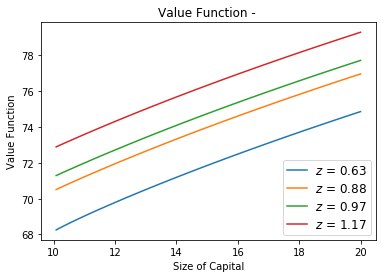

In [7]:
# Plot value function at several iterations
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(round(shock_grid[0],2)))
ax.plot(k_grid[1:], VF[1:, 25], label='$z$ = ' + str(round(shock_grid[25],2)))
ax.plot(k_grid[1:], VF[1:, 50], label='$z$ = ' + str(round(shock_grid[50],2)))
ax.plot(k_grid[1:], VF[1:, 99], label='$z$ = ' + str(round(shock_grid[99],2)))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function - ')
plt.show()

<Figure size 432x288 with 0 Axes>

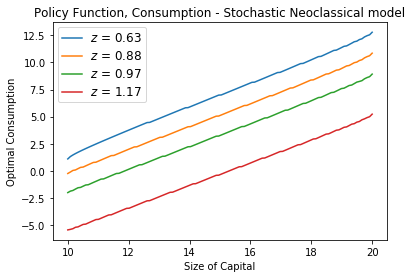

In [8]:
#Plot optimal consumption rule as a function of captal
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optc[:][0], label='$z$ = ' + str(round(shock_grid[0],2)))
ax.plot(k_grid[:], optc[:][25], label='$z$ = ' + str(round(shock_grid[25],2)))
ax.plot(k_grid[:], optc[:][50], label='$z$ = ' + str(round(shock_grid[50],2)))
ax.plot(k_grid[:], optc[:][99], label='$z$ = ' + str(round(shock_grid[99],2)))
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, Consumption - Stochastic Neoclassical model')
plt.show()

<Figure size 432x288 with 0 Axes>

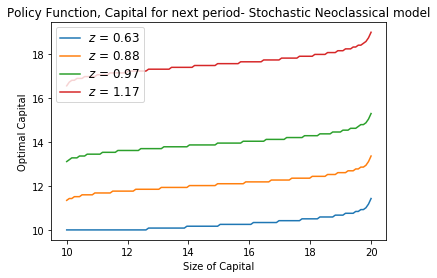

In [9]:
#Plot optimal capital next period rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
#ax.plot(k_grid[1:], optk[1:], label='Capital next period')
#ax.plot(k_grid[1:], k_grid[1:], '--', label='Y = X line')
ax.plot(k_grid[:], optk[:][0], label='$z$ = ' + str(round(shock_grid[0],2)))
ax.plot(k_grid[:], optk[:][25], label='$z$ = ' + str(round(shock_grid[25],2)))
ax.plot(k_grid[:], optk[:][50], label='$z$ = ' + str(round(shock_grid[50],2)))
ax.plot(k_grid[:], optk[:][99], label='$z$ = ' + str(round(shock_grid[99],2)))
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Capital')
plt.title('Policy Function, Capital for next period- Stochastic Neoclassical model')
plt.show()